# Example: Higgs to 4 Muons


In this example, we will follow the [cms open data analyses](https://github.com/cms-opendata-analyses/HiggsExample20112012). Repeat the Higgs discovery (Higgs to 4 Muons) with the Coffea language. 

Selections/cuts used are from this [Analyzer](https://github.com/cms-opendata-analyses/HiggsExample20112012/blob/master/HiggsDemoAnalyzer/src/HiggsDemoAnalyzerGit.cc).


In [1]:
%matplotlib inline
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema

The original data format used in this analyses is imcompatible with Coffea. I manually extracted related informations with this [analyser](https://github.com/yihui-lai/HiggsExample20112012/blob/master/HiggsDemoAnalyzer/src/HiggsDemoAnalyzerGit.cc) and stored them as flat root ntuple (`samples/Higgs4L1file.root`). 

In [2]:
events = NanoEventsFactory.from_root(
    "../../samples/Higgs4L1file.root",
    "demo/ttree",
    entry_stop=10000,
    schemaclass=NanoAODSchema
).events()
events.fields

['event', 'Electron', 'luminosityBlock', 'run', 'Muon']

Here we begin the selections on events

In [3]:
#select global particle flow muons
selected_muons = events.Muon[events.Muon.isPFMuon & events.Muon.isPFIsolationValid & events.Muon.hasglobalTrack]
print("muon total number: ",ak.sum(ak.num(selected_muons)))

#good muons 
selected_muons = selected_muons[ (np.abs(np.sqrt(selected_muons.dxy**2+selected_muons.dz**2)/np.sqrt(selected_muons.dxyErr**2+selected_muons.dzErr**2))<4) & 
                                 (np.abs(selected_muons.dxy)<0.5) & 
                                 (np.abs(selected_muons.dz)<1) & 
                                 (np.abs(selected_muons.pfRelIso04_all)<0.4) &
                                 (selected_muons.pt>5) & 
                                 (np.abs(selected_muons.eta)<2.4) ]
print("good muon total number: ", ak.sum(ak.num(selected_muons)))


#ZZ to 4Muons
selected_muons = selected_muons[ak.num(selected_muons) >=4]
print("events (nmuon>=4) number: ",len(selected_muons))


muon total number:  9880
good muon total number:  7992
events (nmuon>=4) number:  327


In [4]:
#sort from high pt to low pt
selected_muons = selected_muons[ak.argsort(selected_muons.pt, axis=-1, ascending=False)]
#only need the first 4 muons
selected_muons = selected_muons[:,0:4]
# total charge need to be 0
selected_muons[ak.sum(selected_muons[:,:,"charge"],axis=-1) == 0]
print("events (charge==0) number: ", len(selected_muons))
# 6 combinations: mu1mu2, mu1mu3, mu1mu4, mu2mu3, mu2mu4, mu3mu4
# after charge selection, only 4 combinations preserved 
selected_muon_pair = ak.combinations(selected_muons, 2)
selected_muon_pair = selected_muon_pair[((selected_muon_pair["0"][:,"charge"]+selected_muon_pair["1"][:,"charge"])==0)]

events (charge==0) number:  327


In [5]:
# define a function used to find the combination with mass closest to real Z mass
def closest(muon_pair):
    delta = abs(91.1876 - muon_pair.mass[:])
    closest_masses = np.min(delta,axis=-1)
    is_closest = (delta == closest_masses)
    return is_closest

In [6]:
# get the mask for the closest z boson and another z boson
z_pair = (selected_muon_pair["0"] + selected_muon_pair["1"])
za_mask = closest(z_pair)
zb_mask = ak.from_iter(za_mask[:,[3,2,1,0]])
# best combination of muons, za is closer to real Z boson mass
zamuons = selected_muon_pair[za_mask]
zbmuons = selected_muon_pair[zb_mask]
zamuons = ak.flatten(zamuons)
zbmuons = ak.flatten(zbmuons)

In [7]:
print(zamuons.type)
print(zbmuons.type)

327 * (muon, muon)
327 * (muon, muon)


In [8]:
# requirement on mass of za, zb
isgoodmza = (((zamuons["0"]+zamuons["1"]).mass>40)&((zamuons["0"]+zamuons["1"]).mass<120))
isgoodmzb = (((zbmuons["0"]+zbmuons["1"]).mass>12)&((zbmuons["0"]+zbmuons["1"]).mass<120))
# another requirement on za 
isgoodpt = (zamuons["0"].pt>20)&(zamuons["1"].pt>10)
Goodza = zamuons[isgoodpt&isgoodmza&isgoodmzb]
Goodzb = zbmuons[isgoodpt&isgoodmza&isgoodmzb]

In [9]:
# add 4 muons 
higgs = Goodza['0']+Goodza['1'] + Goodzb['0']+Goodzb['1']
higgs = higgs[higgs.mass>70]
print("final events number:",len(higgs))

final events number: 284


In [10]:
print(higgs.mass)

[110, 123, 126, 123, 122, 125, 124, 126, ... 126, 123, 127, 124, 125, 127, 125, 117]


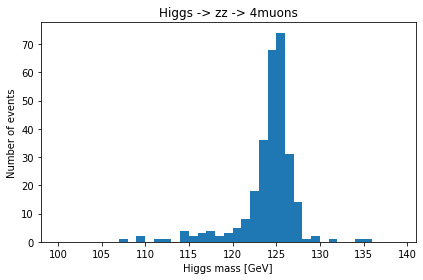

In [11]:
import matplotlib.pyplot as plt
bins = np.arange(100, 140, 1)
fig, ax = plt.subplots()
n, bins, patches = ax.hist(higgs.mass, bins=bins,)
ax.set_xlabel('Higgs mass [GeV]')
ax.set_ylabel('Number of events')
ax.set_title(r'Higgs -> zz -> 4muons')

fig.tight_layout()
plt.show()


## Write the previous code again within processor framwork 

In [12]:
import coffea.processor as processor
from coffea import hist

def closest(muon_pair):
    delta = abs(91.1876 - muon_pair.mass[:])
    closest_masses = np.min(delta,axis=-1)
    is_closest = (delta == closest_masses)
    return is_closest

class Processor(processor.ProcessorABC):
    def __init__(self):
        # Bins and categories for the histogram are defined here. For format, see https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html && https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Bin.html
        dataset_axis = hist.Cat("dataset", "")
        Higgs_axis = hist.Bin("Higgs", "Higgs [GeV]", 40, 100, 140)
        
        # The accumulator keeps our data chunks together for histogramming. It also gives us cutflow, which can be used to keep track of data.
        self._accumulator = processor.dict_accumulator({
            'Higgs': hist.Hist("Counts", dataset_axis, Higgs_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        selected_muons = events.Muon[events.Muon.isPFMuon & events.Muon.isPFIsolationValid & events.Muon.hasglobalTrack]
        
        output['cutflow']['all muons'] += ak.sum(ak.num(selected_muons))

        selected_muons = selected_muons[ (np.abs(np.sqrt(selected_muons.dxy**2+selected_muons.dz**2)/np.sqrt(selected_muons.dxyErr**2+selected_muons.dzErr**2))<4) & 
                                        (np.abs(selected_muons.dxy)<0.5) & 
                                        (np.abs(selected_muons.dz)<1) & 
                                        (np.abs(selected_muons.pfRelIso04_all)<0.4) &
                                        (selected_muons.pt>5) & 
                                        (np.abs(selected_muons.eta)<2.4) ]
        output['cutflow']['good muons'] += ak.sum(ak.num(selected_muons))

        selected_muons = selected_muons[ak.num(selected_muons) >=4]
        output['cutflow']['events with 4 good muons'] += len(selected_muons)

        selected_muons = selected_muons[ak.argsort(selected_muons.pt, axis=-1, ascending=False)]
        selected_muons = selected_muons[:,0:4]
        selected_muons[ak.sum(selected_muons[:,:,"charge"],axis=-1) == 0]

        selected_muon_pair = ak.combinations(selected_muons, 2)
        selected_muon_pair = selected_muon_pair[((selected_muon_pair["0"][:,"charge"]+selected_muon_pair["1"][:,"charge"])==0)]

        z_pair = (selected_muon_pair["0"] + selected_muon_pair["1"])
        za_mask = closest(z_pair)
        zb_mask = ak.from_iter(za_mask[:,[3,2,1,0]])

        zamuons = selected_muon_pair[za_mask]
        zbmuons = selected_muon_pair[zb_mask]
        zamuons = ak.flatten(zamuons)
        zbmuons = ak.flatten(zbmuons)

        isgoodmza = (((zamuons["0"]+zamuons["1"]).mass>40)&((zamuons["0"]+zamuons["1"]).mass<120))
        isgoodmzb = (((zbmuons["0"]+zbmuons["1"]).mass>12)&((zbmuons["0"]+zbmuons["1"]).mass<120))
        isgoodpt = (zamuons["0"].pt>20)&(zamuons["1"].pt>10)

        Goodza = zamuons[isgoodpt&isgoodmza&isgoodmzb]
        Goodzb = zbmuons[isgoodpt&isgoodmza&isgoodmzb]
        higgs = Goodza['0']+Goodza['1'] + Goodzb['0']+Goodzb['1']
        
        output['cutflow']['final events'] += len(higgs.mass)
        output['cutflow']['number of chunks'] += 1
        
        output['Higgs'].fill(dataset=dataset, Higgs=higgs.mass)
        return output

    def postprocess(self, accumulator):
        return accumulator

In [13]:
events = NanoEventsFactory.from_root(
    "../../samples/Higgs4L1file.root",
    "demo/ttree",
    entry_stop=10000,
    metadata={"dataset": "Higgs_to_4muons"},
    schemaclass=NanoAODSchema
).events()
p = Processor()
output = p.process(events)
output

{'Higgs': <Hist (dataset,Higgs) instance at 0x7fcc5ae30c40>,
 'cutflow': defaultdict_accumulator(int,
                         {'all muons': 9880,
                          'good muons': 7992,
                          'events with 4 good muons': 327,
                          'final events': 284,
                          'number of chunks': 1})}

<AxesSubplot:xlabel='Higgs [GeV]', ylabel='Counts'>

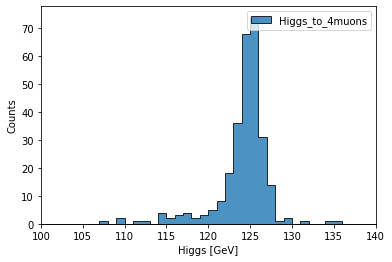

In [14]:
hist.plot1d(output['Higgs'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})